# Glidelytics for Strava - paragliding analysis on personal Strava data
## Authentication 

1. Get client_id from
https://www.strava.com/settings/api. In your first time you need to create an app to get this info.

2. Visit page 
http://www.strava.com/oauth/authorize?client_id=[YOUR_CLIENT_ID]&response_type=code&redirect_uri=http://localhost/exchange_token&approval_prompt=force&scope=read_all
replacing placeholder with client_id. This step is not needed if you only want to access your public activities (read scope which is default). In that case you can skip step 3 and copy your access code directly to the config.ini file (step 4)

Get field "code" from response after redirection, finding it on the response URL (it will look like an error response). 

Using postman or CURL, make a POST request to https://www.strava.com/oauth/token?client_id=[YOUR_CLIENT_ID]&client_secret=[YOUR_CLIENT_SECRET]&code=[CODE_FROM_PREVIOUS_STEP]&grant_type=authorization_code

You should get a response with an authorization token, a refresh token and a validity (expires_at)

Open file config.ini (or else create such file on root using example_config.ini). Update the file with the below fields and save:
- client_id
- client_secret
- access_token
- refresh_token
- expires_at (in seconds from epoch format - same as the above response)


In [33]:
import datetime
import requests
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
import pandas as pd
from pandas import json_normalize

auth_url = "https://www.strava.com/oauth/token"
activites_url = "https://www.strava.com/api/v3/athlete/activities"
activity_url = "https://www.strava.com/api/v3/activities/"

config_filename = "config.ini"

In [34]:
# Lets load the config info and token expiracy time
import configparser
config = configparser.ConfigParser()
config.read(config_filename)
print("Client ID: {}".format(config["strava"]["client_id"]))

expires_at_epoch = int(config["strava"]["expires_at"])
expires_at_date = datetime.datetime.fromtimestamp(expires_at_epoch)
refresh_token = config["strava"]["refresh_token"]
access_token = config["strava"]["access_token"]
print("Token expires at: {}".format(expires_at_date))

Client ID: 80263
Token expires at: 2022-04-05 15:29:29


In [35]:
# If a token is outdated we need to refresh it (happens often at the start of a script)
if datetime.datetime.now() >= expires_at_date:
    print("Refreshing token")
    payload = {
        'client_id': config["strava"]["client_id"],
        'client_secret': config["strava"]["client_secret"],
        'refresh_token': refresh_token,
        'grant_type': "refresh_token",
        'f': 'json'
    }

    try:
        response = requests.post(auth_url, data=payload, verify=False).json()
        access_token = response['access_token']
        refresh_token = response['refresh_token']
        expires_at_epoch = int(response['expires_at'])
        expires_at_date = datetime.datetime.fromtimestamp(expires_at_epoch)
        print("Token refreshed successtully and expires at: {}".format(expires_at_date))
    except:
        print("Problem refreshing token")
    
    # writes refreshed values to config file
    config.set("strava", "access_token", access_token)
    config.set("strava", "refresh_token", refresh_token)
    config.set("strava", "expires_at", str(expires_at_epoch))
    with open(config_filename, 'w') as configfile:
        config.write(configfile)
else:
    print("Token still valid")

In [32]:
# request header using valid token
header = {'Authorization': 'Bearer ' + access_token}

1649165369


## Getting list of paragliding activities

In [56]:
# estimate of number of activities
act_total = 400
# activities per page
act_pp = 100
# number of pages
import math
pgs = math.ceil(act_total / act_pp)

# columns to keep from activities
cols = ["id", "name", "distance", "moving_time", "elapsed_time", "total_elevation_gain", "type", "start_date_local", "map.id", "average_speed", "max_speed", "elev_high", "elev_low"]

pg_contents = []
for pg in range(pgs):
    if datetime.datetime.now() >= expires_at_date:
        print("Token outdated")
        break
    print("Page: {}".format(pg + 1))
    param = {'per_page': act_pp, 'page': pg + 1}
    try:
        pg_dataset = requests.get(activites_url, headers=header, params=param).json()
        #print(pg_dataset)
        pg_activities = json_normalize(pg_dataset)
    except:
        print("Problem accessing API")
        break
    pg_activities = pg_activities[cols]
    print("retrieved {} activities".format(pg_activities.shape[0]))
    print(pg_activities.head(5))
    pg_contents.append(pg_activities)
    
my_activities = pd.concat(pg_contents)
print("Total of {} activities retrieved".format(my_activities.shape[0]))

Page: 1
   resource_state                name  distance  moving_time  elapsed_time  \
0               2      Afternoon Hike       0.0           88            88   
1               2        Morning Hike    4980.0         4261          7040   
2               2  Afternoon Activity    6536.0         6050         15264   
3               2           Lunch Run    9760.0         3420          3420   
4               2           Lunch run    9766.6         3461          3482   

   total_elevation_gain     type          id            start_date  \
0                   0.0     Hike  6906273468  2022-03-30T12:16:20Z   
1                   0.0     Hike  6895088466  2022-03-27T07:13:53Z   
2                 707.0  Workout  6886935853  2022-03-26T12:55:13Z   
3                   0.0      Run  6878705037  2022-03-24T11:47:21Z   
4                  32.3      Run  6869475041  2022-03-23T11:49:38Z   

       start_date_local  ... has_kudoed  athlete.id athlete.resource_state  \
0  2022-03-30T14:16:20Z 

## Tagging paragliding activities

In [21]:
# All my paragliding activities have ""#glidelytics" in their description
# Given the API allows for only 100 calls every 15 min, I will first select "workouts" as my paragliding activities are always of that kind
my_workouts = my_activities[my_activities["type"] == "Workout"]

my_activities["paragliding"]  = False
my_activities["contains_hike"]  = False
my_activities["multiple_runs"]  = False

for index, row in my_workouts.iterrows():
    param = {'include_all_efforts' : "false"}
    url = activity_url + str(index)
    try:
        res = requests.get(url, headers=header, params=param).json()
    except:
        print("Problem getting activity {} details".format(row["id"]))
        break
    description = res["description"]
    print("Activity {}: description: {}".format(str(index), description))
    if description:
        if "#glidelytics" in description:
            my_activities.loc[index, ["paragliding"]] = True
            print("Tagged as paragliding")
        if "#contains_hike" in description:
            my_activities.loc[index, ["contains_hike"]] = True
            print("Tagged as containing hike")
        if "#multiple_runs" in description:
            my_activities.loc[index, ["multiple_runs"]] = True
            print("Tagged as multiple runs")

    

Activity 6886935853: description: None
Activity 6852021252: description: #glidelytics
#low_def
Tagged as paragliding
Activity 6563578794: description: #glidelytics
Tagged as paragliding
Activity 6455422418: description: #glidelytics
Tagged as paragliding
Activity 6450725938: description: #glidelytics
Tagged as paragliding
Activity 6282811526: description: #glidelytics
#contains_hike
Tagged as paragliding
Tagged as containing hike
Activity 6241816861: description: #glidelytics
#contains_hike
Tagged as paragliding
Tagged as containing hike
Activity 6119791259: description: None
Activity 6086233364: description: #glidelytics
#contains_hike
#multiple_runs
Tagged as paragliding
Tagged as containing hike
Tagged as multiple runs
Activity 6016387895: description: #glidelytics
#contains_hike
#multiple_runs
Tagged as paragliding
Tagged as containing hike
Tagged as multiple runs
Activity 5838259029: description: #glidelytics
#contains_hike
#multiple_runs
Tagged as paragliding
Tagged as containing

In [22]:
# store data in file
my_activities.to_csv("My_activities.csv")

## Data exploration

In [4]:
# retrieve from csv (ONLY in case starting notebook from here!)
my_activities = pd.read_csv("My_activities.csv", index_col = 0)
#my_activities.set_index("id", inplace = True)
print(my_activities.head())

                          name  distance  moving_time  elapsed_time  \
id                                                                    
6906273468      Afternoon Hike       0.0           88            88   
6895088466        Morning Hike    4980.0         4261          7040   
6886935853  Afternoon Activity    6536.0         6050         15264   
6878705037           Lunch Run    9760.0         3420          3420   
6869475041           Lunch run    9766.6         3461          3482   

            total_elevation_gain     type      start_date_local       map.id  \
id                                                                             
6906273468                   0.0     Hike  2022-03-30T14:16:20Z  a6906273468   
6895088466                   0.0     Hike  2022-03-27T09:13:53Z  a6895088466   
6886935853                 707.0  Workout  2022-03-26T13:55:13Z  a6886935853   
6878705037                   0.0      Run  2022-03-24T12:47:21Z  a6878705037   
6869475041            

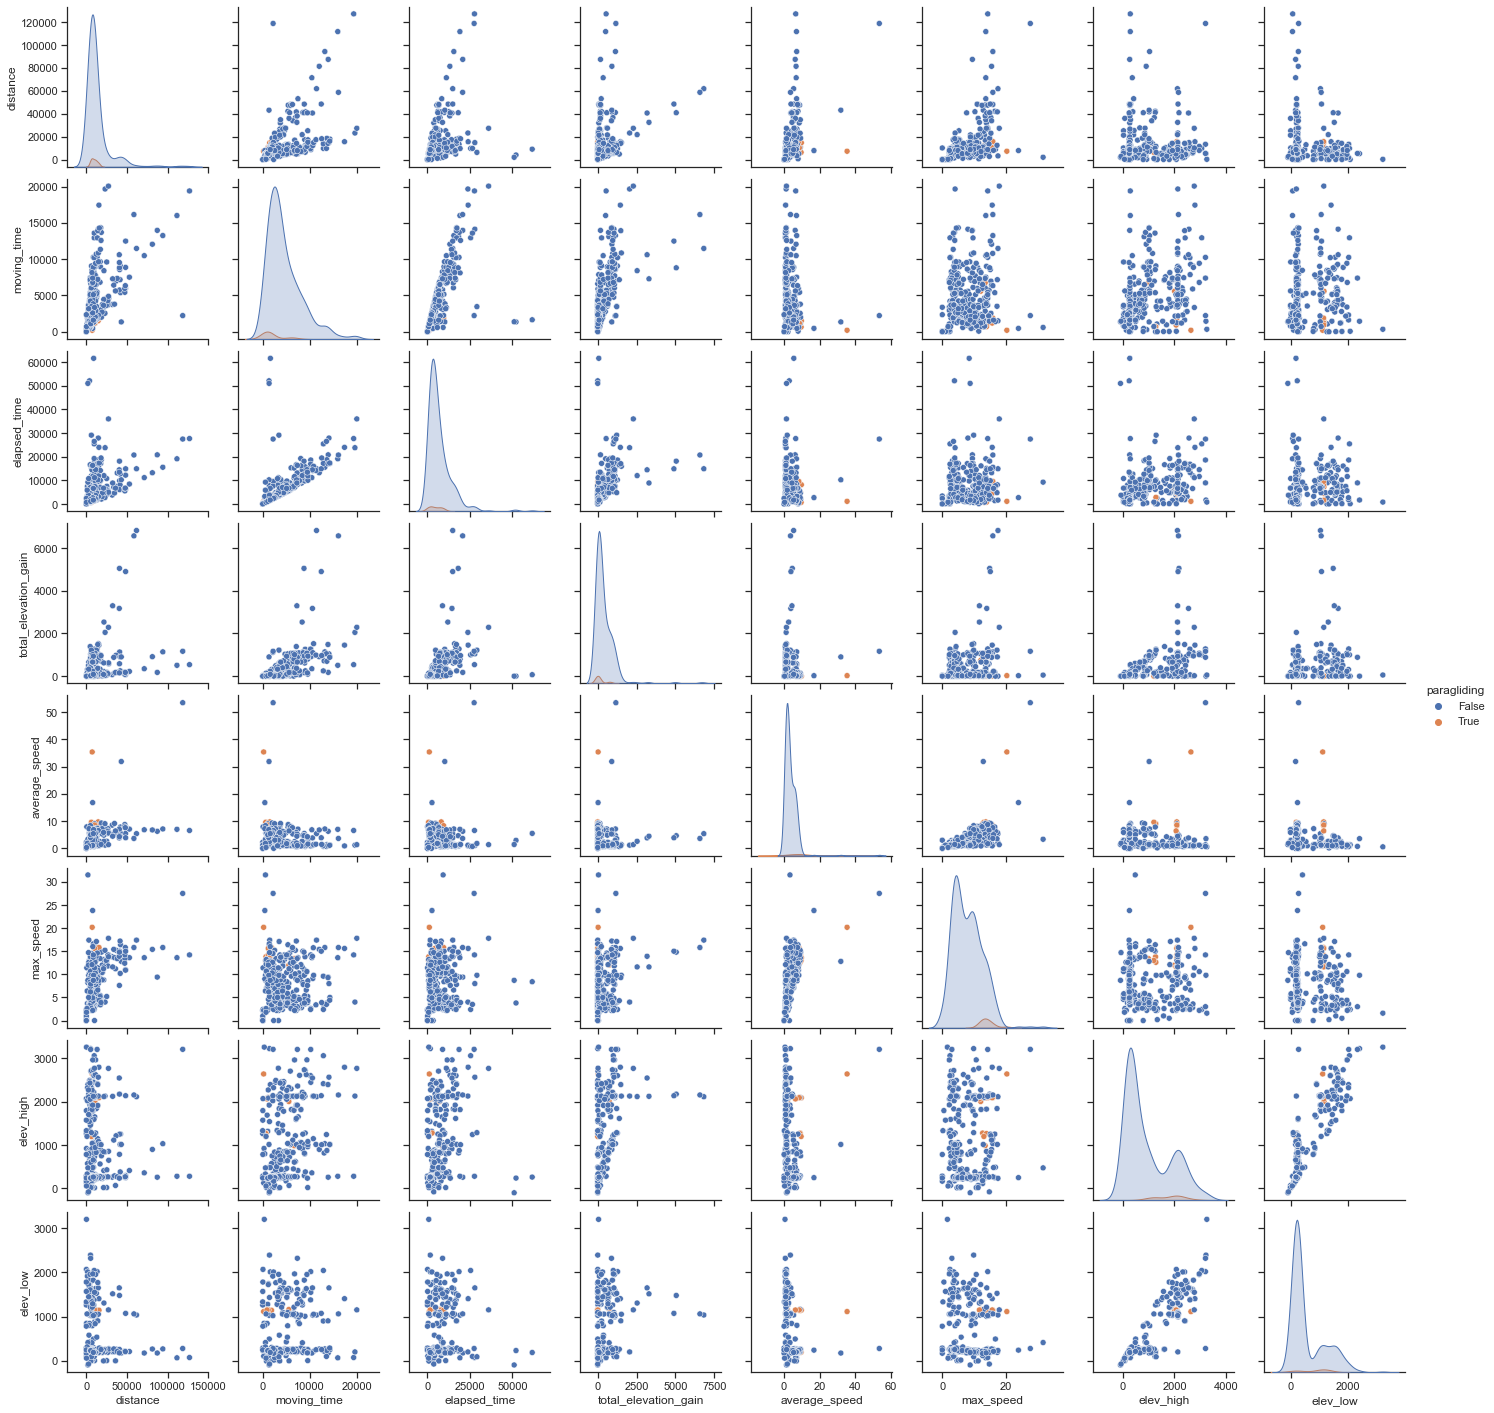

In [7]:
import seaborn as sns
sns.set_theme(style="ticks")

cols_to_analyze = ["distance", "moving_time", "elapsed_time", "total_elevation_gain", "average_speed", "max_speed", "elev_high", "elev_low", "paragliding"]
sns.pairplot(my_activities[cols_to_analyze], hue = "paragliding")


As expected, there isn't much that can be done with the normal data that Strava API sends. We shall need to get real elevation data to do a good classifying job. Let's try to see the performance of a classifier

## Simple classifier

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier


cols_to_analyze = ["paragliding", "distance", "moving_time", "elapsed_time", "total_elevation_gain", "average_speed", "max_speed", "elev_high", "elev_low"]
dataset = my_activities[cols_to_analyze]
dataset = dataset.dropna()

X = dataset[cols_to_analyze]
X = StandardScaler().fit_transform(X)
y = dataset["paragliding"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 42)

print("Train set has {} activities".format(len(y_train)))
parag_activities = len([act for act in y_train if act == True])
print("Out of which {} are paragliding".format(parag_activities))
      
classifier = MLPClassifier(alpha = 1, max_iter = 1000)
classifier.fit(X_train, y_train)

print("Test set has {} activities".format(len(y_test)))
parag_activities = len([act for act in y_test if act == True])
print("Out of which {} are paragliding".format(parag_activities))
predictions = classifier.predict(X_test)
paragliding_non_tagged = 0
other_activity_tagged = 0
correctly_tagged = 0
y_test_array = [y for y in y_test]
for index in range(len(y_test_array)):
    if y_test_array[index] == False and predictions[index] == True:
        other_activity_tagged += 1
    elif y_test_array[index] == True and predictions[index] == False:
        paragliding_non_tagged +=1
    else:
        correctly_tagged += 1
        
print("Classifier did {} correct classifications".format(correctly_tagged))
print("A total of {} paragliding activities were not correctly tagged".format(paragliding_non_tagged))
print("A total of {} activities were wrongfully tagged as paragliding".format(other_activity_tagged))


score = classifier.score(X_test, y_test)
print("The calculated score of the classifier is {}".format(score))


Train set has 214 activities
Out of which 8 are paragliding
Test set has 144 activities
Out of which 3 are paragliding
Classifier did 144 correct classifications
A total of 0 paragliding activities were not tagged
A total of 0 activities were wrongfully tagged as paragliding
The calculated score of the classifier is 1.0
